![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    XGBoost gap-filling
</b>: Minimal example    
</span>

---
**Notebook version**: `1` (26 Apr 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- Using [XGBoost](https://xgboost.readthedocs.io/en/stable/) to gap-fill time series data

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [1]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import numpy as np
import importlib.metadata
from datetime import datetime
import matplotlib.pyplot as plt
from diive.configs.exampledata import load_exampledata_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.77.0


</br>

# **Docstring** for `XGBoostTS`

In [3]:
# help(XGBoostTS)

</br>

---

# **Load data**

## Load example data from parquet file

In [4]:
source_df = load_exampledata_parquet()

Loaded .parquet file F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.058 seconds). Detected time resolution of <30 * Minutes> / 30min 


## Make subset

In [5]:
df = source_df.copy()
lowquality = df["QCF_NEE"] > 0  # This example uses NEE flux data, only records where the quality flag QCF is 0 (highest quality) are retained
df.loc[lowquality, TARGET_COL] = np.nan  # Set fluxes of lower quality to missing
df = df[subsetcols].copy()  # Keep subset columns only

In [6]:
df.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,41284.000000,175296.000000,175296.000000,175296.000000
mean,-3.833522,4.712999,3.233176,152.671445
std,6.085449,7.548653,3.710180,247.531312
min,-38.653000,-23.096000,0.000000,0.000000
25%,-7.840000,-0.800000,0.661000,0.000000
50%,-3.827000,4.600000,1.991000,2.596000
75%,0.606250,10.067000,4.375000,225.677750
max,25.290000,28.713000,32.118000,1197.800000


In [7]:
sstats(df[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2013-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,3651 days 23:30:00
NOV,41284
MISSING,134012
MISSING_PERC,76.448978
MEAN,-3.833522
MEDIAN,-3.827
SD,6.085449
VAR,37.032694


F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\plotting\timeseries.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


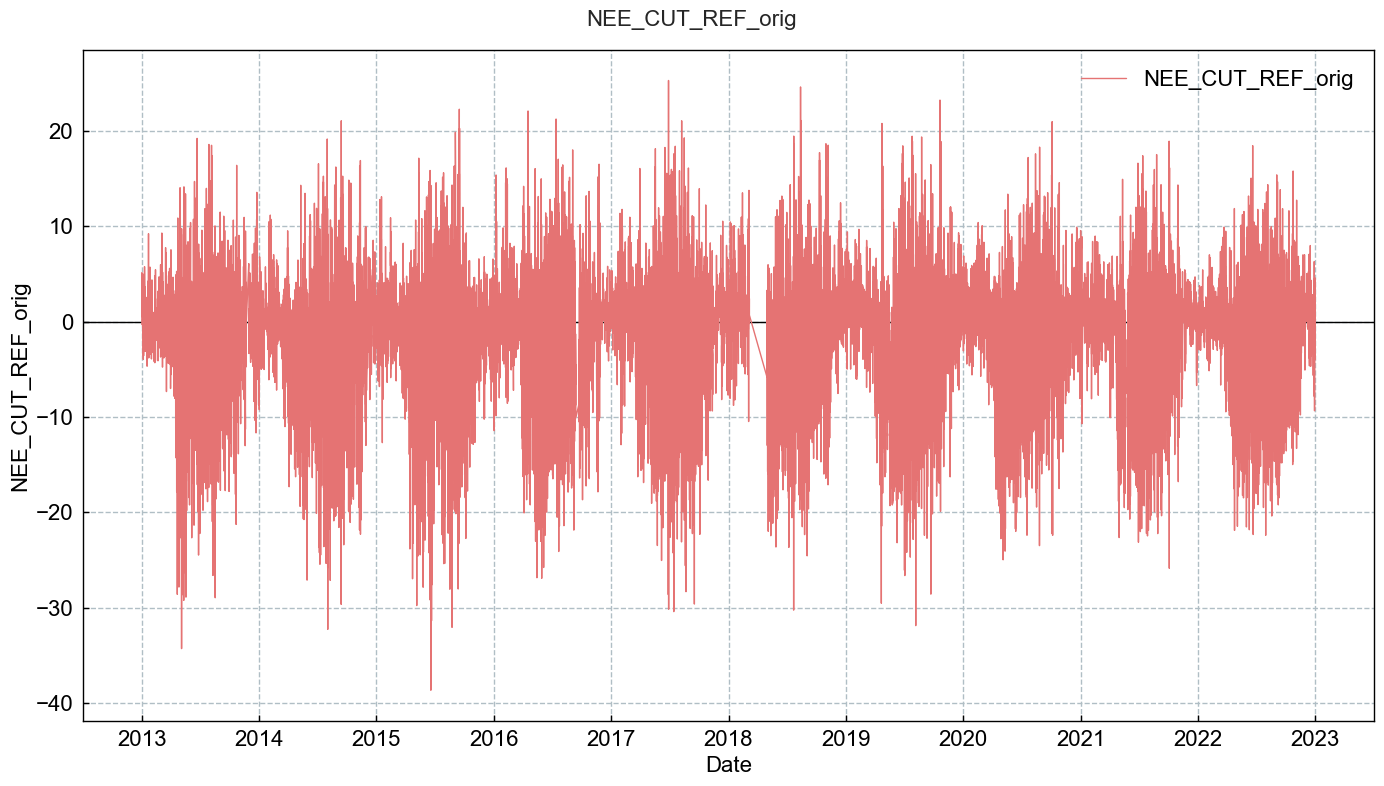

In [8]:
# TimeSeries(series=df[TARGET_COL]).plot_interactive()
TimeSeries(series=df[TARGET_COL]).plot()

</br>

</br>

# **Gap-filling**

## Initialize XGBoost

In [9]:
xgbts = XGBoostTS(
        input_df=df,
        target_col=TARGET_COL,                    
        n_estimators=99,        
        random_state=42,  # To keep results consistent between runs
        n_jobs=-1  # Use all available CPU cores
    )

</br>

## Feature reduction

In [10]:
xgbts.reduce_features()


Feature reduction based on permutation importance ...
[0]	validation_0-rmse:5.01108	validation_1-rmse:5.01108
[1]	validation_0-rmse:4.35933	validation_1-rmse:4.35933
[2]	validation_0-rmse:3.98451	validation_1-rmse:3.98451
[3]	validation_0-rmse:3.76789	validation_1-rmse:3.76789
[4]	validation_0-rmse:3.64007	validation_1-rmse:3.64007
[5]	validation_0-rmse:3.57429	validation_1-rmse:3.57429
[6]	validation_0-rmse:3.52608	validation_1-rmse:3.52608
[7]	validation_0-rmse:3.49588	validation_1-rmse:3.49588
[8]	validation_0-rmse:3.47963	validation_1-rmse:3.47963
[9]	validation_0-rmse:3.46211	validation_1-rmse:3.46211
[10]	validation_0-rmse:3.44841	validation_1-rmse:3.44841
[11]	validation_0-rmse:3.43867	validation_1-rmse:3.43867
[12]	validation_0-rmse:3.43220	validation_1-rmse:3.43220
[13]	validation_0-rmse:3.42738	validation_1-rmse:3.42738
[14]	validation_0-rmse:3.41881	validation_1-rmse:3.41881
[15]	validation_0-rmse:3.41232	validation_1-rmse:3.41232
[16]	validation_0-rmse:3.40303	validation_1

In [11]:
xgbts.report_feature_reduction()


FEATURE REDUCTION

- Target variable: NEE_CUT_REF_orig

- The random variable .RANDOM was added to the original features, used as benchmark for detecting relevant feature importances.

PERMUTATION IMPORTANCE (mean) across all splits of TimeSeriesSplit:

         PERM_IMPORTANCE   PERM_SD
Rg_f            1.466295  0.011949
Tair_f          0.976333  0.004159
VPD_f           0.477902  0.001685
.RANDOM         0.053397  0.000129

- These results are from feature reduction. Note that feature importances for the final model are calculated during gap-filling.

--> 3 original input features (before feature reduction): ['Tair_f', 'VPD_f', 'Rg_f']
--> 5 rejected features (during feature reduction): None.
--> 3 accepted features (after feature reduction): ['Rg_f', 'Tair_f', 'VPD_f']



</br>

## Train model


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2013-01-01 01:45:00 and 2022-12-31 22:15:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:5.01108	validation_1-rmse:5.05953
[1]	validation_0-rmse:4.35951	validation_1-rmse:4.42750
[2]	validation_0-rmse:3.98517	validation_1-rmse:4.06539
[3]	validation_0-rmse:3.76884	validation_1-rmse:3.85628
[4]	validation_0-rmse:3.64142	validation_1-rmse:3.73519
[5]	validation_0-rmse:3.57611	validation_1-rmse:3.67822
[6]	validation_0-rmse:3.52944	validation_1-rmse:3.63491
[7]	validation_0-rmse:3.50143	validation_1-rmse:3.61349
[8]	validation_0-rmse:3.48092	validation_1-rmse:3.59861
[9]	validation_0-rmse:3.46514	validation_1-rmse:3.58808
[10]	validation_0-rmse:3.45432	validation_1-rmse:3.58406
[11]	validation_0-rmse:3.44647	validation_1-rmse:3.58118
[12]	validation_0-rmse:3.43922	validation_1-rmse:3.58045
[13]	validation_0-rmse:3.43482	validation_1-rmse:3.58008
[14]	validation_0-r

F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\ml\common.py:1130: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


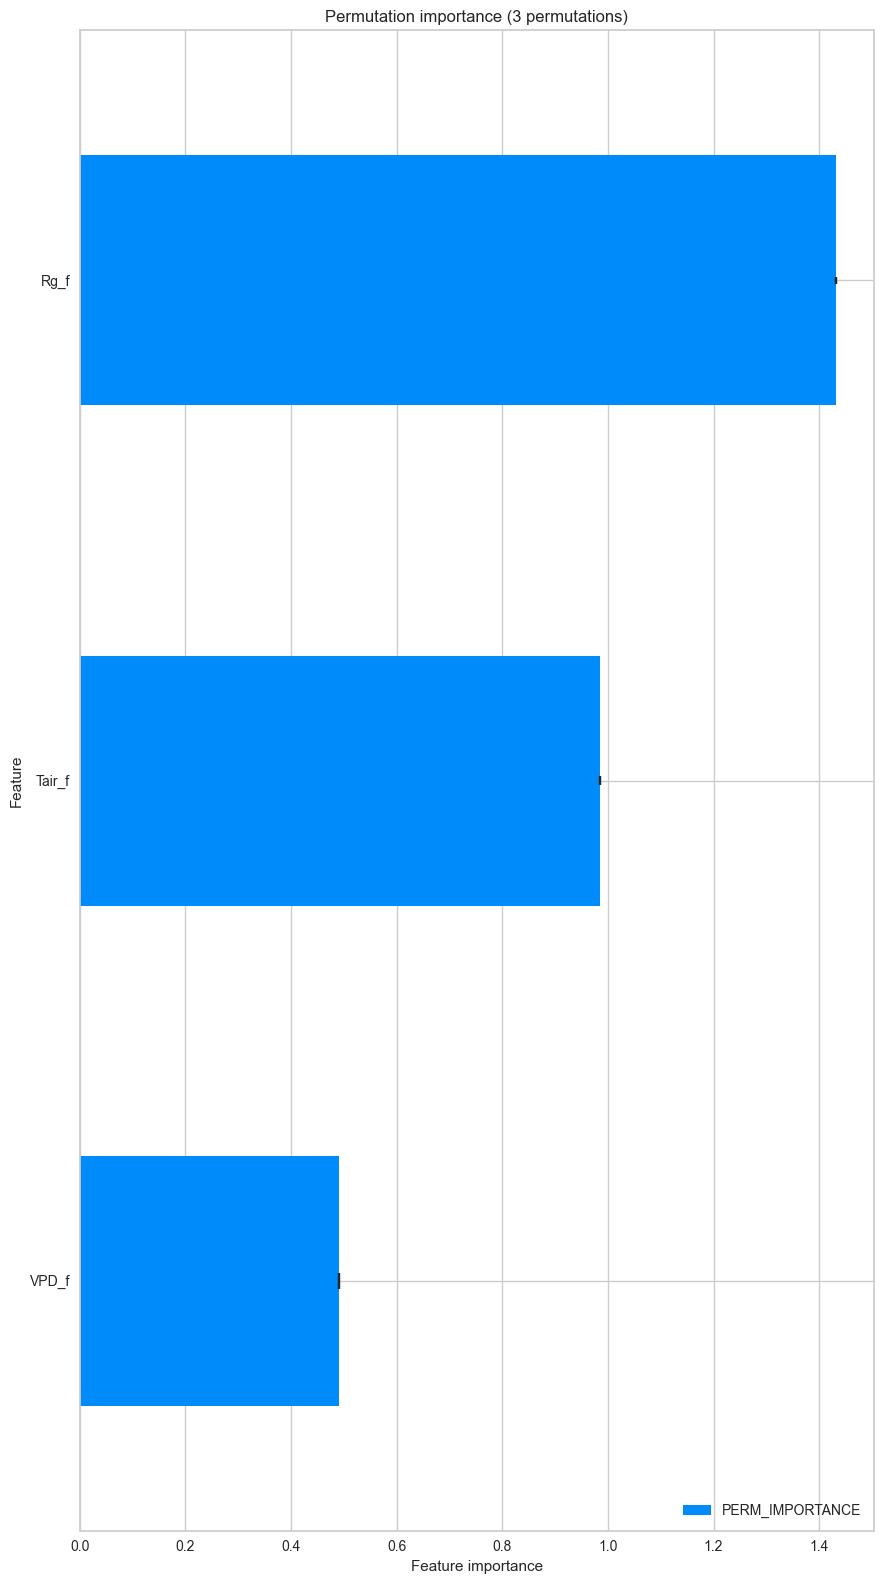

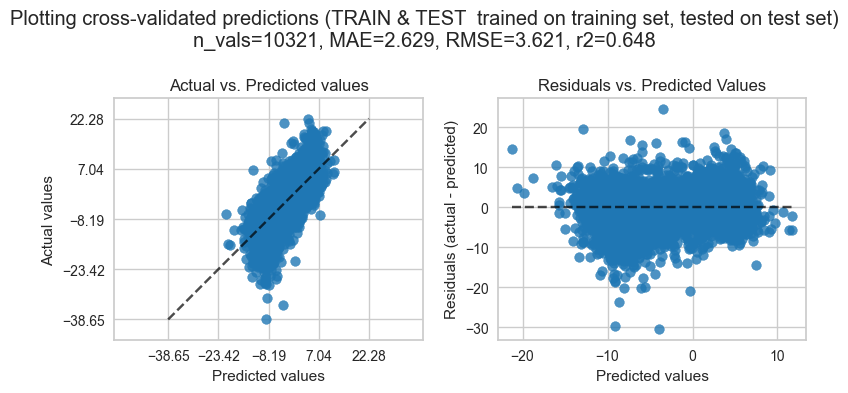

>>> Plotting residuals and prediction error ...


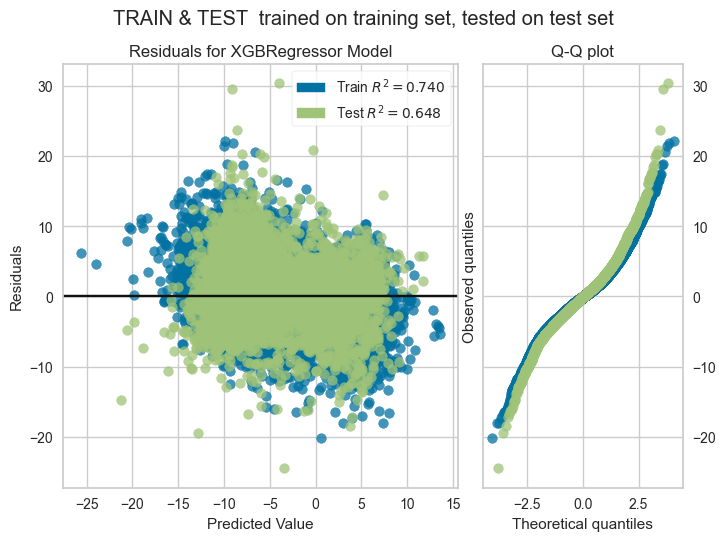

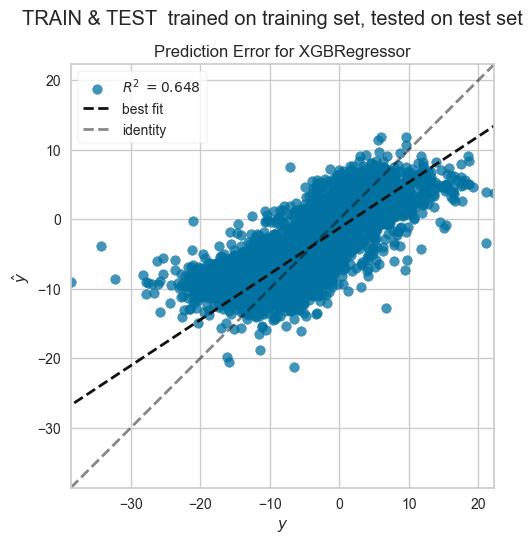

>>> Collecting results, details about training and testing can be accessed by calling .report_traintest().
>>> Done.


In [12]:
xgbts.trainmodel(showplot_scores=True, showplot_importance=True)

In [13]:
xgbts.report_traintest()


MODEL TRAINING & TESTING RESULTS

## DATA
  > target: NEE_CUT_REF_orig
  > features: 3 ['Rg_f', 'Tair_f', 'VPD_f']
  > 175296 records (with missing)
  > 41284 available records for target and all features (no missing values)
  > training on 30963 records (75.0%) of 30963 features between 2013-01-01 01:45:00 and 2022-12-31 22:15:00
  > testing on 10321 unseen records (25.0%) of NEE_CUT_REF_orig between 2013-01-01 06:15:00 and 2022-12-29 17:45:00

## MODEL
  > the model was trained on training data (30963 records)
  > the model was tested on test data (10321 values)
  > estimator:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=No

</br>

## Apply model to fill gaps


Gap-filling using final model ...
>>> Using final model on all data to predict target NEE_CUT_REF_orig ...
>>> Using final model on all data to calculate permutation importance ...
>>> Plotting feature importances (permutation importance) ...
>>> Calculating prediction scores based on all data predicting NEE_CUT_REF_orig ...
>>> Plotting observed and predicted values based on all data ...


F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\ml\common.py:1130: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


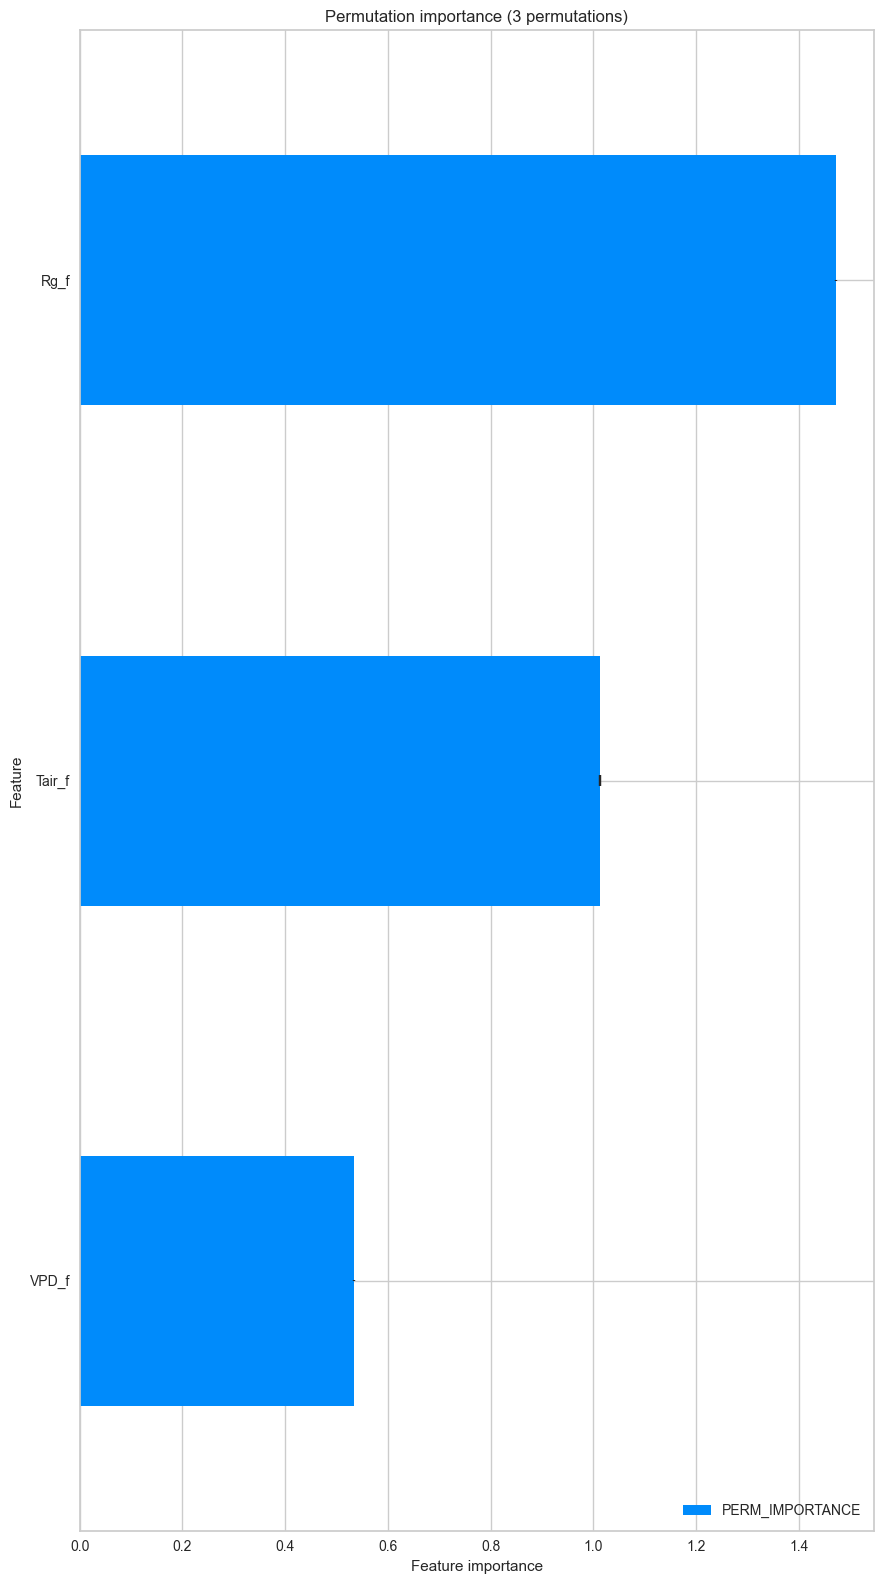

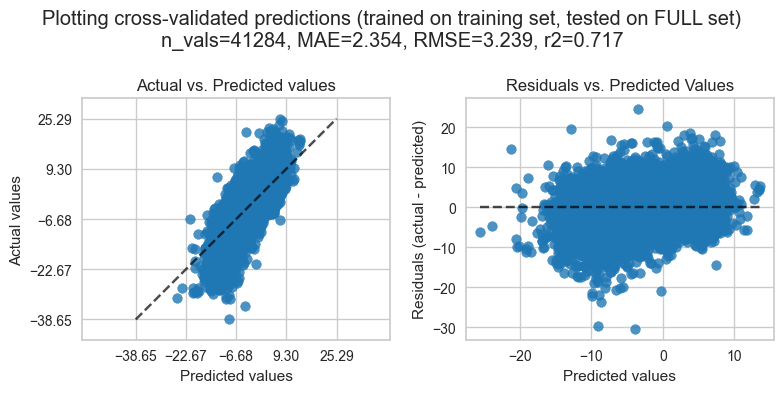

>>> Predicting target NEE_CUT_REF_orig where all features are available ... predicted 175296 records.
>>> Collecting results for final model ...
>>> Filling 134012 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable NEE_CUT_REF_orig_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...


In [14]:
xgbts.fillgaps(showplot_scores=True, showplot_importance=True)

In [15]:
xgbts.report_gapfilling()


GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (134012 values, NEE_CUT_REF_orig_gfXG where flag=1) in comparison to observed targets (41284 values, NEE_CUT_REF_orig).

## TARGET
- first timestamp:  2013-01-01 00:15:00
- last timestamp:  2022-12-31 23:45:00
- potential number of values: 175296 values)
- target column (observed):  NEE_CUT_REF_orig
- missing records (observed):  134012 (cross-check from flag: 134012)
- target column (gap-filled):  NEE_CUT_REF_orig_gfXG  (175296 values)
- missing records (gap-filled):  0
- gap-filling flag: FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED
  > flag 0 ... observed targets (41284 values)
  > flag 1 ... targets gap-filled with high-quality, all features available (134012 values)
  > flag 2 ... targets gap-filled with fallback (0 values)

## FEATURE IMPORTANCES
- names of features used in model:  ['Rg_f', 'Tair_f', 'VPD_f']
- number of features used in model:  3
- permutation importances were c

</br>

## Attributes
A lot more information about feature reduction, training and testing, model building and gap-filling is available via the class attributes.

In [16]:
xgbts.feature_importances_

,PERM_IMPORTANCE,PERM_SD
Rg_f,1.472943,0.000404
Tair_f,1.012613,0.010995
VPD_f,0.533626,0.001541


In [17]:
xgbts.gapfilling_df_

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED,NEE_CUT_REF_orig_gfXG,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,0.934018,NaN,0.934018,1,0.934018,None,0.934018,0.934018
2013-01-01 00:45:00,0.934018,NaN,0.934018,1,0.934018,None,1.868036,0.934018
2013-01-01 01:15:00,0.934018,NaN,0.934018,1,0.934018,None,2.802054,0.934018
2013-01-01 01:45:00,0.934018,0.538,NaN,0,0.538000,None,3.340054,0.934018
2013-01-01 02:15:00,1.141467,NaN,1.141467,1,1.141467,None,4.481521,1.141467
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,2.483982,NaN,2.483982,1,2.483982,None,-77770.442364,2.483982
2022-12-31 22:15:00,2.860891,3.518,NaN,0,3.518000,None,-77766.924364,2.860891
2022-12-31 22:45:00,3.422467,NaN,3.422467,1,3.422467,None,-77763.501898,3.422467


In [18]:
xgbts.model_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=99, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [19]:
xgbts.accepted_features_

['Rg_f', 'Tair_f', 'VPD_f']

In [20]:
xgbts.rejected_features_

'None.'

In [21]:
xgbts.scores_

{'mae': 2.354464972058204,
 'medae': 1.745812363624573,
 'mse': 10.493141619548462,
 'rmse': 3.239311905258347,
 'mape': 243055457128.11444,
 'maxe': 30.350757015228268,
 'r2': 0.7166450879804251}

</br>

## Result

In [22]:
gapfilled = xgbts.get_gapfilled_target()
gapfilled

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    0.934018
2013-01-01 00:45:00    0.934018
2013-01-01 01:15:00    0.934018
2013-01-01 01:45:00    0.538000
2013-01-01 02:15:00    1.141467
                         ...   
2022-12-31 21:45:00    2.483982
2022-12-31 22:15:00    3.518000
2022-12-31 22:45:00    3.422467
2022-12-31 23:15:00    3.312062
2022-12-31 23:45:00    3.145486
Freq: 30min, Name: NEE_CUT_REF_orig_gfXG, Length: 175296, dtype: float64

In [23]:
flag = xgbts.get_flag()
flag

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    1
2013-01-01 00:45:00    1
2013-01-01 01:15:00    1
2013-01-01 01:45:00    0
2013-01-01 02:15:00    1
                      ..
2022-12-31 21:45:00    1
2022-12-31 22:15:00    0
2022-12-31 22:45:00    1
2022-12-31 23:15:00    1
2022-12-31 23:45:00    1
Freq: 30min, Name: FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED, Length: 175296, dtype: int32

In [24]:
gapfilling_df = xgbts.gapfilling_df_
gapfilling_df

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED,NEE_CUT_REF_orig_gfXG,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,0.934018,NaN,0.934018,1,0.934018,None,0.934018,0.934018
2013-01-01 00:45:00,0.934018,NaN,0.934018,1,0.934018,None,1.868036,0.934018
2013-01-01 01:15:00,0.934018,NaN,0.934018,1,0.934018,None,2.802054,0.934018
2013-01-01 01:45:00,0.934018,0.538,NaN,0,0.538000,None,3.340054,0.934018
2013-01-01 02:15:00,1.141467,NaN,1.141467,1,1.141467,None,4.481521,1.141467
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,2.483982,NaN,2.483982,1,2.483982,None,-77770.442364,2.483982
2022-12-31 22:15:00,2.860891,3.518,NaN,0,3.518000,None,-77766.924364,2.860891
2022-12-31 22:45:00,3.422467,NaN,3.422467,1,3.422467,None,-77763.501898,3.422467


</br>

## Plot

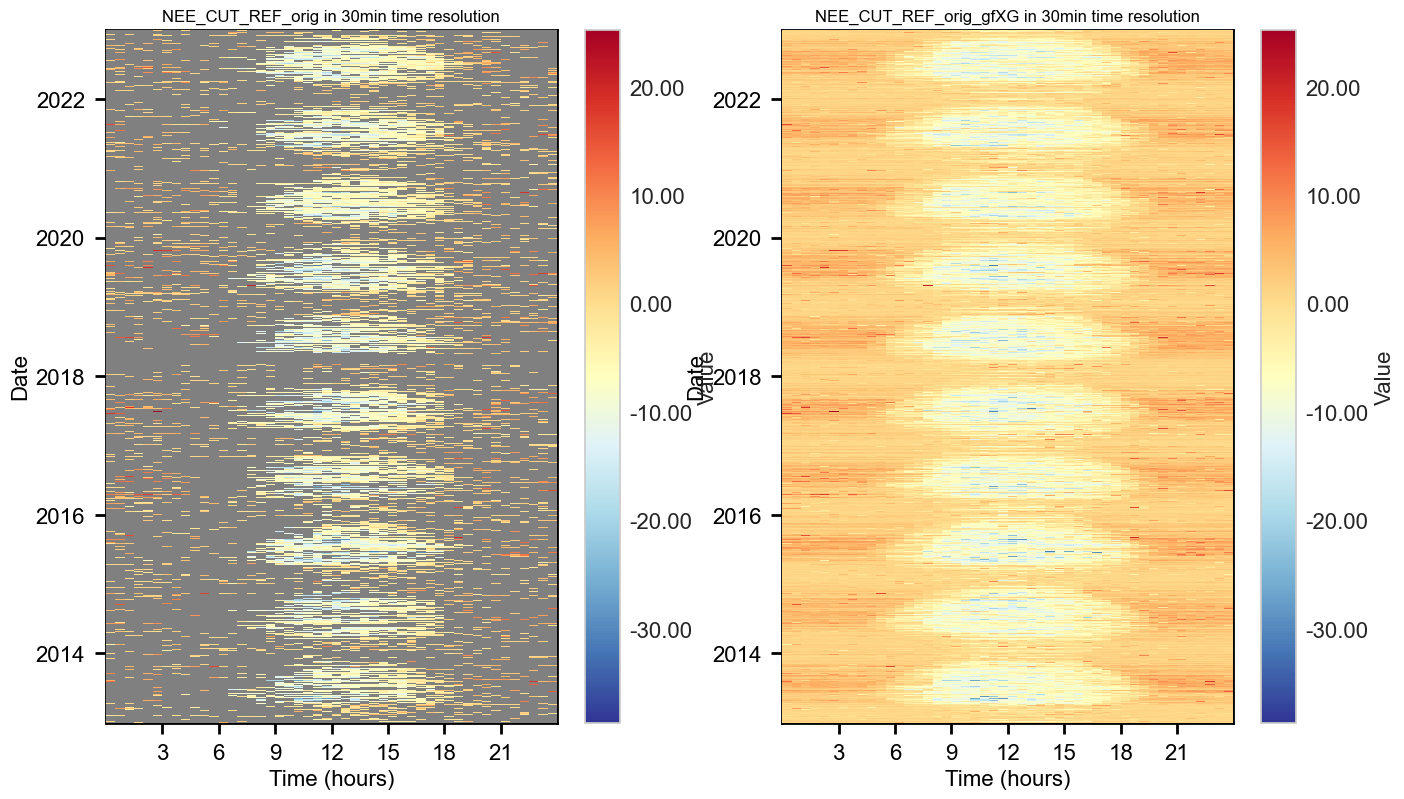

In [25]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 9))
HeatmapDateTime(series=df[TARGET_COL], ax=axs[0]).plot()
HeatmapDateTime(series=gapfilled, ax=axs[1]).plot()

F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\plotting\timeseries.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


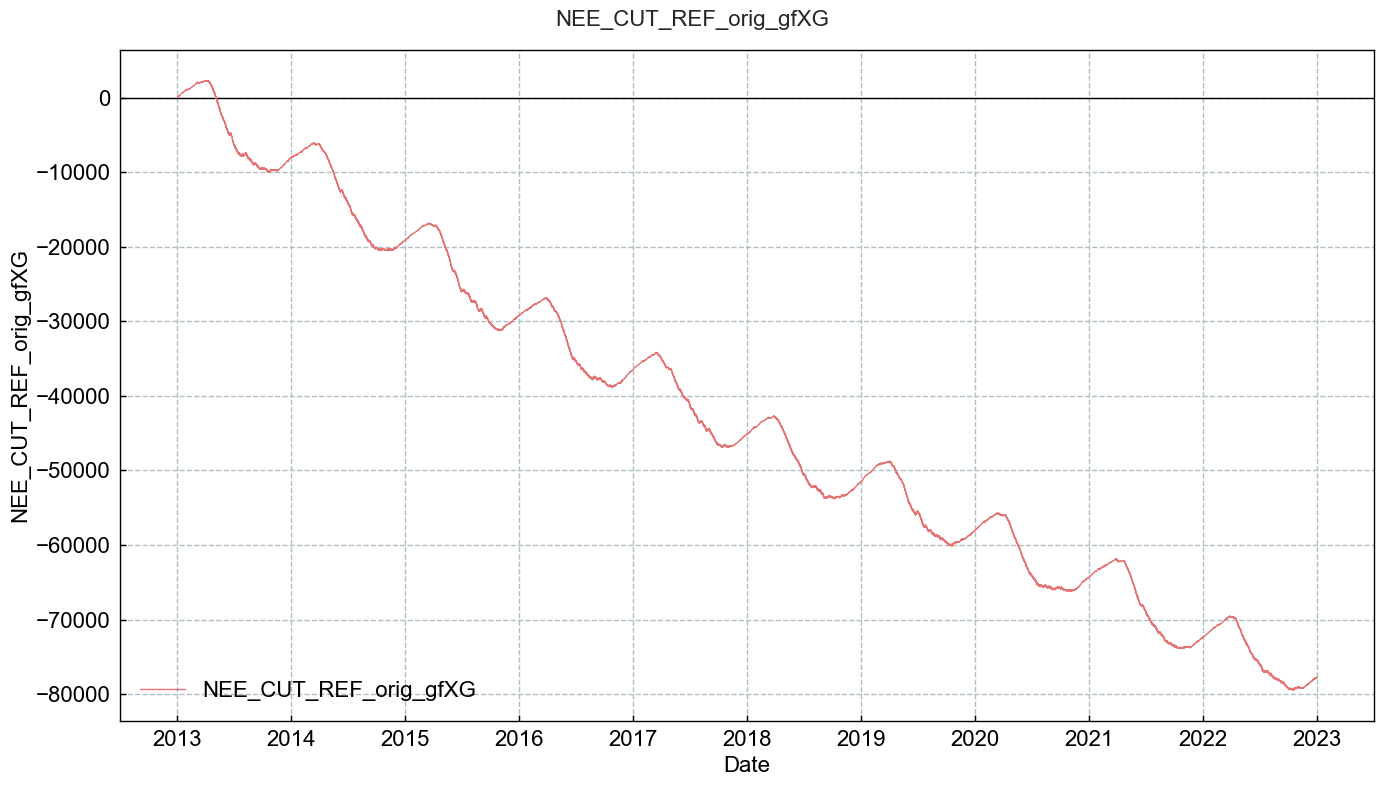

In [26]:
TimeSeries(gapfilled.cumsum()).plot()

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [27]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-06-11 15:15:56
